In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_dataset(image_size=(128, 128)):
  (ds_train, ds_validation), ds_info = tfds.load(
      'oxford_flowers102',
      split=['train', 'validation'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )

  num_classes = ds_info.features['label'].num_classes

  def preprocess(image, label):
    image = tf.image.resize(image, image_size)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

  ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(64).prefetch(tf.data.AUTOTUNE)
  ds_validation = ds_validation.map(preprocess).cache().batch(64).prefetch(tf.data.AUTOTUNE)

  return ds_train, ds_validation, num_classes, ds_info

In [ ]:
IMG_SIZE = (224, 224)
train_dataset, validation_dataset, num_classes, ds_info = load_dataset(IMG_SIZE)

class_names=ds_info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.JGPOFS_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.JGPOFS_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.JGPOFS_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


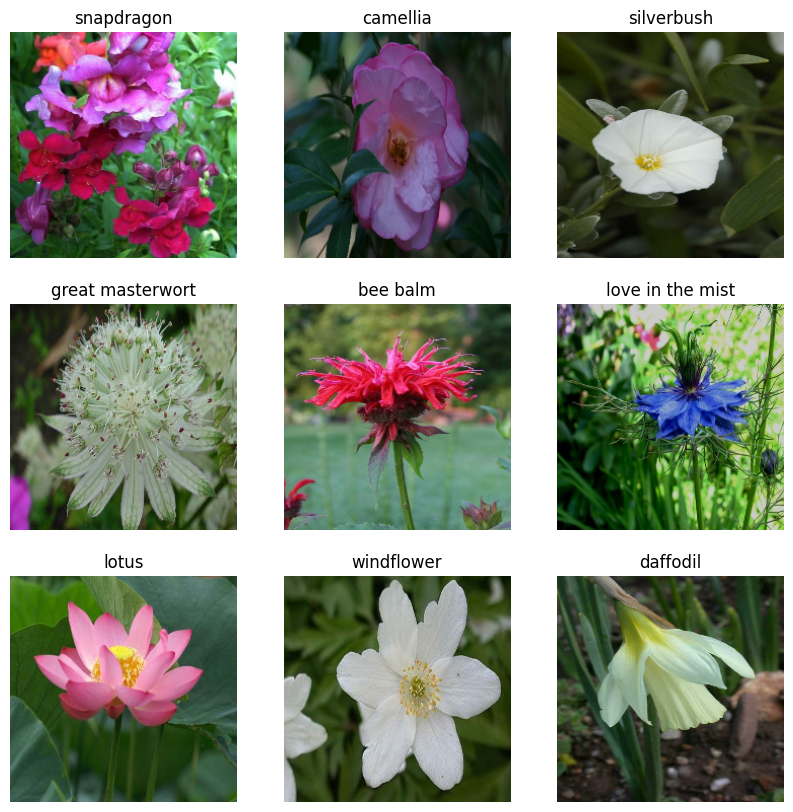

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip("horizontal"))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation

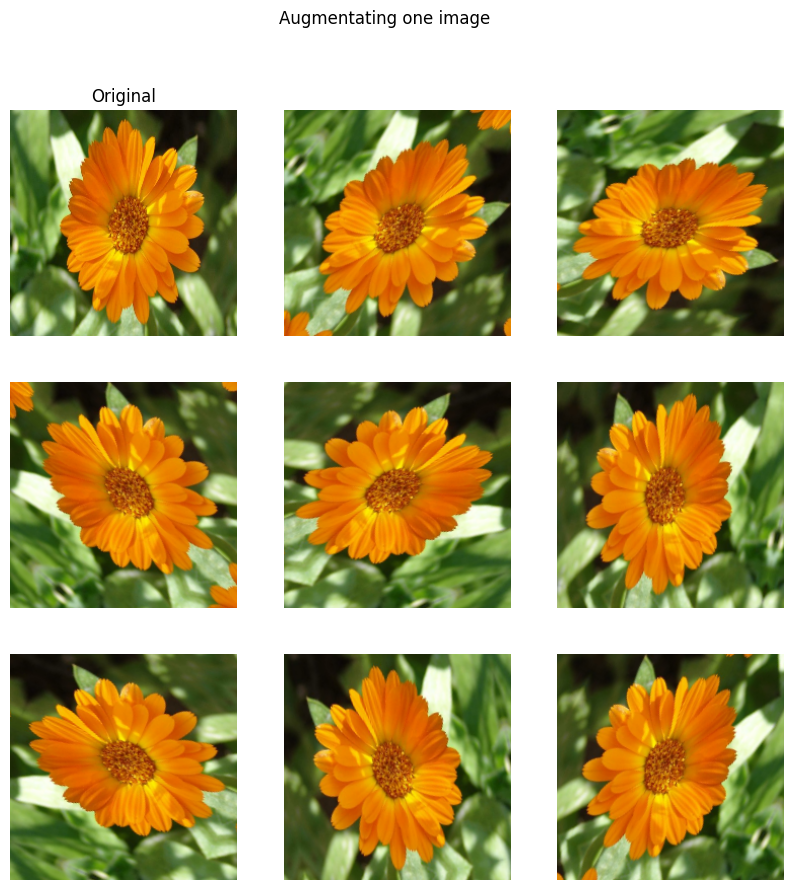

In [ ]:
data_augmentation = data_augmenter()

for images, labels in train_dataset.take(1):
    first_image = images[0]

    plt.figure(figsize=(10, 10))
    plt.suptitle("Augmentating one image")

    ax = plt.subplot(3, 3, 1)
    plt.imshow(first_image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis('off')

    for i in range(8):
        ax = plt.subplot(3, 3, i + 2)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')

plt.show()


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
train_dataset_resnet = train_dataset.map(lambda image, label: (preprocess_input_resnet(image), label))

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
def flower_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
  input_shape = image_shape + (3,)

  base_model = ResNet50(input_shape=input_shape,
                       include_top=False,
                       weights='imagenet',
                      name='resnet50')

  base_model.trainable = False

  inputs = Input(shape=input_shape)

  x = data_augmentation(inputs)

  x = preprocess_input_resnet(x)

  x = base_model(x, training=False)

  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.2)(x)

  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)

  return model


In [ ]:
model = flower_model(IMG_SIZE, data_augmenter())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history = model.fit(train_dataset,
                                  epochs=10,
                                  validation_data=validation_dataset)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 786ms/step - accuracy: 0.0378 - loss: 5.0652 - val_accuracy: 0.2157 - val_loss: 3.4401
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 528ms/step - accuracy: 0.2963 - loss: 3.1039 - val_accuracy: 0.6010 - val_loss: 2.1921
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - accuracy: 0.6511 - loss: 1.8754 - val_accuracy: 0.7069 - val_loss: 1.5941
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 522ms/step - accuracy: 0.8073 - loss: 1.2012 - val_accuracy: 0.7647 - val_loss: 1.2687
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step - accuracy: 0.8852 - loss: 0.8730 - val_accuracy: 0.7951 - val_loss: 1.0831
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 531ms/step - accuracy: 0.9030 - loss: 0.7272 - val_accuracy: 0.8147 - val_loss: 0.9800
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step - accuracy: 0.9374 - loss: 0.5427 - val_accuracy: 0.8196 - val_loss: 0.8886
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.9475 - loss: 0.4568 - val_accuracy: 0

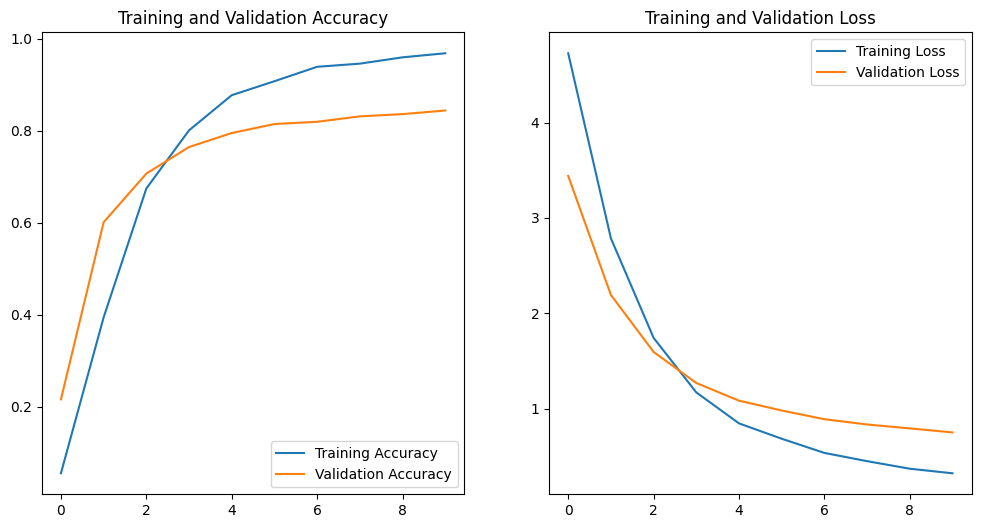

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.8479 - loss: 0.7328
Validation Loss: 0.7504
Validation Accuracy: 84.41%


In [ ]:
base_model = model.get_layer('resnet50')
base_model.trainable = True

# ResNet has 175 layers
fine_tune_at = 165 # Finetuning 25 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

fine_tune_epochs = 30
total_epochs = 10 + fine_tune_epochs

history_fine_tune = model.fit(train_dataset,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=validation_dataset)


Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 738ms/step - accuracy: 0.9997 - loss: 0.0322 - val_accuracy: 0.8578 - val_loss: 0.6236
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 551ms/step - accuracy: 1.0000 - loss: 0.0297 - val_accuracy: 0.8588 - val_loss: 0.6208
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 0.8598 - val_loss: 0.6182
Epoch 13/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 553ms/step - accuracy: 0.9998 - loss: 0.0266 - val_accuracy: 0.8598 - val_loss: 0.6167
Epoch 14/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.9996 - loss: 0.0243 - val_accuracy: 0.8608 - val_loss: 0.6155
Epoch 15/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - accuracy: 1.0000 - loss: 0.0258 - val_accuracy: 0.8618 - val_loss: 0.6141
Epoch 16/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 544ms/step - accuracy: 0.9991 - loss: 0.0287 - val_accuracy: 0.8618 - val_loss: 0.6123
Epoch 17/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 551ms/step - accuracy: 1.0000 - loss: 0.0246 - val_ac

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.8780 - loss: 0.5152
Validation Loss: 0.5757
Validation Accuracy: 86.27%
